#Aula 6 - Manutenção Preditiva na prática utilizando Aprendizado de Máquina



In [1]:
#Montagem do drive a partir da pasta raiz do google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#instalação do scikit-plot
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Criação de gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Manipulação de dados/algebra linear.
import numpy as np
import pandas as pd

# Métricas e utilidades.
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

# Algoritmos
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier as xgb

# Outros
import warnings

In [4]:
# Algumas Configurações.
%matplotlib inline
# Definindo estilo do Seaborn
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

In [5]:
#Leitura das bases de dados
erros_df = pd.read_csv('gdrive/My Drive/Senai_Aula6/Manutencao_preditiva_Dados/erros.csv')
falhas_df = pd.read_csv('gdrive/My Drive/Senai_Aula6/Manutencao_preditiva_Dados/falhas.csv')
manutencao_df = pd.read_csv('gdrive/My Drive/Senai_Aula6/Manutencao_preditiva_Dados/manutencao.csv')
maquinas_df = pd.read_csv('gdrive/My Drive/Senai_Aula6/Manutencao_preditiva_Dados/maquinas.csv')
telemetria_df = pd.read_csv('gdrive/My Drive/Senai_Aula6/Manutencao_preditiva_Dados/telemetria.csv', error_bad_lines=False)


b'Skipping line 92490: expected 6 fields, saw 9\n'


# Descrição das base de dados

As bases de dados erros.csv, falhas.csv, manutencao.csv, maquinas.csv e telemetria.csv contém as informações:

* Histórico de falhas: o histórico de falhas de uma máquina ou componente dentro da máquina.

* Histórico de manutenção: o histórico de reparos de uma máquina, por exemplo, códigos de erro, atividades de manutenção anteriores ou substituição de componentes.

* Condições e uso de máquinas: As condições de operação de uma máquina, por exemplo, dados coletados de sensores.

* Características da máquina: As características de uma máquina, como por exemplo, tamanho do motor, modelo e idade.

### Dados de telemetria

Dados de séries temporais de telemetria com medições de tensão, rotação, pressão e vibração coletadas de 100 máquinas em tempo real com média de cada hora coletada durante o ano de 2015.

In [6]:
 telemetria_df.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [7]:
 telemetria_df.tail()

,datetime,machineID,volt,rotate,pressure,vibration
968583,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
968584,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
968585,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
968586,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259
968587,2016-01-01 06:00:00,100,171.336037,496.096870,79.095538,37.845245


In [8]:
telemetria_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968588 entries, 0 to 968587
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   968588 non-null  object 
 1   machineID  968588 non-null  int64  
 2   volt       968588 non-null  float64
 3   rotate     968588 non-null  float64
 4   pressure   968588 non-null  float64
 5   vibration  968588 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 44.3+ MB


In [9]:
telemetria_df.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [10]:
telemetria_df["machineID"].nunique()

100

In [11]:
# Alteramos o formato do atributo "datetime" que faz a medição do tempo de cada amostra, pois ele vem como uma string.
telemetria_df["datetime"] = pd.to_datetime(telemetria_df["datetime"], format="%Y-%m-%d %H:%M:%S")
telemetria_df.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [12]:
# el dtype de esta serie es objeto porque tiene tipos mixtos
telemetria_df.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

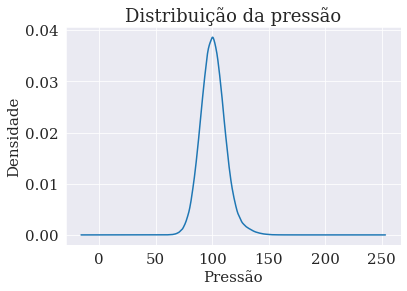

In [13]:
# Kernel Density function -> PDF (Função de densidade de probabilidade)

"""
Uma distribuição normal nos fala sobre uma amostra representativa (Teorema do Limite Central).
Ele nos fala sobre o comportamento natural.
Mostre um único grupo para trabalhar (caso contrário, faça o agrupamento).
Os modelos paramétricos esperam distribuições normais porque usam a média, std, etc.
Modelos não paramétricos, por exemplo CART (Árvores de Classificação e Regressão), são insensíveis à distribuição dos dados, a única coisa que importa é criar nós que maximizem a separação de classes.
Em outros casos, aplique transformações logarítmicas, regressão quantílica, normalização aos dados.
Paramétrico: Regressão Linear
Não paramétrico: árvore de decisão
Há mudanças ou não à medida que o conjunto de dados cresce?
"""

telemetria_df["pressure"].plot(kind="kde")
plt.title("Distribuição da pressão")
plt.ylabel("Densidade")
plt.xlabel("Pressão")
plt.show()

In [14]:
# Confirmamos a integridade; totais, média, desvio padrão, mínimo, máximo e quantis.
telemetria_df.describe()

,machineID,volt,rotate,pressure,vibration
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,170.774119,446.591205,100.841515,40.383648
std,30.450409,15.507488,52.701718,11.028763,5.366198
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,18.000000,160.298184,412.278255,93.492369,36.778303
50%,45.000000,170.597611,447.555368,100.414332,40.237433
75%,73.000000,181.006196,482.154486,107.535244,43.781329
max,100.000000,255.124717,695.020984,185.951998,76.791072


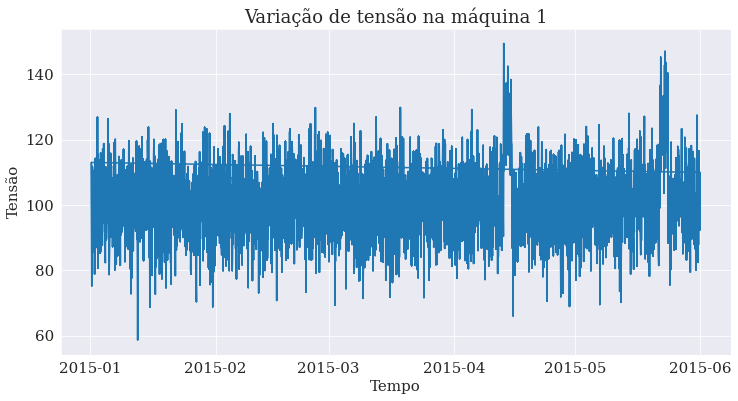

In [15]:
# Mostramos um gráfico de exemplo dos valores de tensão para a máquina 1 durante os primeiros 6 meses de 2015.

plot_df = telemetria_df.loc[
    (telemetria_df["machineID"] == 1)
    & (telemetria_df["datetime"] > pd.to_datetime("2015-01-01"))
    & (telemetria_df["datetime"] < pd.to_datetime("2015-06-01")), ["datetime", "pressure"]
]

plt.figure(figsize=(12, 6))
plt.plot(plot_df["datetime"], plot_df["pressure"])
plt.title("Variação de tensão na máquina 1")
plt.ylabel("Tensão")


adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = "%m-%d"
plt.xlabel("Tempo")
plt.show()

### Erros

Este dataframe corresponde ao erros de aviso gerados enquanto a máquina ainda está em funcionamento e não são considerados falhas. A data e a hora do erro são arredondadas para a hora mais próxima, pois os dados de telemetria são coletados a cada hora.

In [16]:
erros_df.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [17]:
erros_df.tail()

,datetime,machineID,errorID
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3
3918,2015-12-22 03:00:00,100,error3


In [18]:
# Formatando o campo de data e hora que vem como string.
# Categorias permitem comparação entre valores, classificação automática, gráficos mais fáceis e outros recursos.

erros_df["datetime"] = pd.to_datetime(erros_df["datetime"], format="%Y-%m-%d %H:%M:%S")
erros_df["errorID"] = erros_df["errorID"].astype("category")

erros_df.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


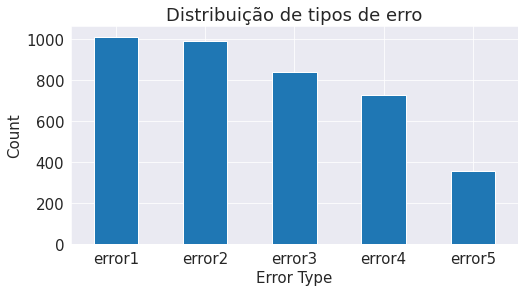

In [19]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
erros_df["errorID"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribuição de tipos de erro")
plt.ylabel("Count")
plt.xlabel("Error Type")
plt.show()

### Manutenção

O Dataframe de manutenção guarda os registros que correspondem a inspeções regulares e falhas. Um registro é gerado se um componente for substituído durante a inspeção programada ou substituído devido a falha. Os registros criados devido a falhas serão chamados de falhas. Os dados de manutenção têm registros de 2014 e 2015.

In [20]:
manutencao_df.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [21]:
manutencao_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3286 non-null   object
 1   machineID  3286 non-null   int64 
 2   comp       3286 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


In [22]:
# Formatando o campo de data e hora que vem como string.

manutencao_df["datetime"] = pd.to_datetime(manutencao_df["datetime"], format="%Y-%m-%d %H:%M:%S")
manutencao_df["comp"] = manutencao_df["comp"].astype("category")
manutencao_df.dtypes

datetime     datetime64[ns]
machineID             int64
comp               category
dtype: object

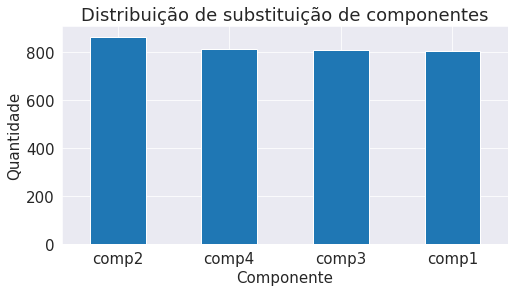

In [23]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
manutencao_df["comp"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribuição de substituição de componentes")
plt.ylabel("Quantidade")
plt.xlabel("Componente")
plt.show()

### Máquinas

Este conjunto de dados inclui informações sobre as máquinas: Modelo e idade (anos em serviço).

In [24]:
maquinas_df.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [25]:
maquinas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   machineID  100 non-null    int64 
 1   model      100 non-null    object
 2   age        100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


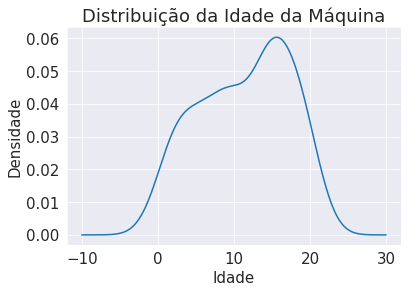

In [26]:
# Verifique se existem várias colinas, pois pode sugerir dois grupos diferentes.
maquinas_df["age"].plot(kind="kde")
plt.title("Distribuição da Idade da Máquina")
plt.xlabel("Idade")
plt.ylabel("Densidade")
plt.show()

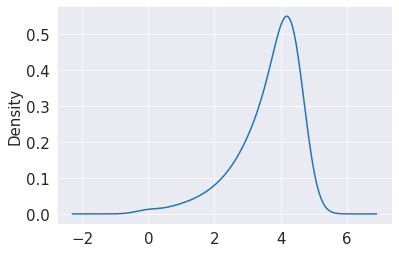

In [27]:
# Aplica-se logaritmo natural para normalizar.
np.log(maquinas_df[maquinas_df["age"] != 0].iloc[:, 0]).plot(kind="kde")
plt.show()

In [28]:
maquinas_df["model"] = maquinas_df["model"].astype("category")
maquinas_df.dtypes

machineID       int64
model        category
age             int64
dtype: object

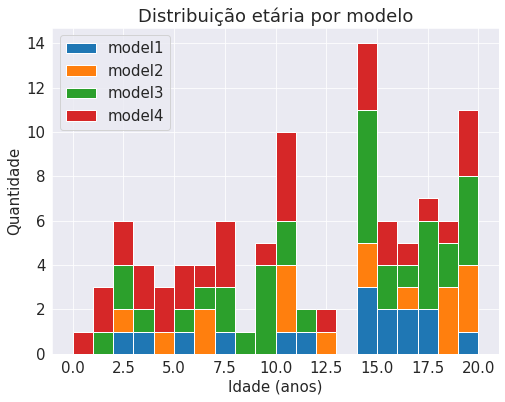

In [29]:
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([
    maquinas_df.loc[maquinas_df["model"] == "model1", "age"],
    maquinas_df.loc[maquinas_df["model"] == "model2", "age"],
    maquinas_df.loc[maquinas_df["model"] == "model3", "age"],
    maquinas_df.loc[maquinas_df["model"] == "model4", "age"]],
    20, stacked=True, label=["model1", "model2", "model3", "model4"
])
plt.title("Distribuição etária por modelo")
plt.xlabel("Idade (anos)")
plt.ylabel("Quantidade")
plt.legend()
plt.show()

### Falhas de componentes

Estes são os registros de substituições de componentes devido a falhas. Cada registro tem uma data e hora, ID de máquina e o componente com falha.

In [30]:
falhas_df.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [31]:
falhas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   761 non-null    object
 1   machineID  761 non-null    int64 
 2   failure    761 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.0+ KB


In [32]:
# Formatamos o datetime que vem como uma string
falhas_df["datetime"] = pd.to_datetime(falhas_df["datetime"], format="%Y-%m-%d %H:%M:%S")
falhas_df["failure"] = falhas_df["failure"].astype("category")
falhas_df.dtypes

datetime     datetime64[ns]
machineID             int64
failure            category
dtype: object

In [33]:
falhas_df.describe(include="all")

,datetime,machineID,failure
count,761,761.000000,761
unique,302,NaN,4
top,2015-01-02 03:00:00,NaN,comp2
freq,18,NaN,259
first,2015-01-02 03:00:00,NaN,NaN
last,2015-12-31 06:00:00,NaN,NaN
mean,NaN,51.911958,NaN
std,NaN,29.515542,NaN
min,NaN,1.000000,NaN
25%,NaN,24.000000,NaN


In [34]:
falhas_df.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


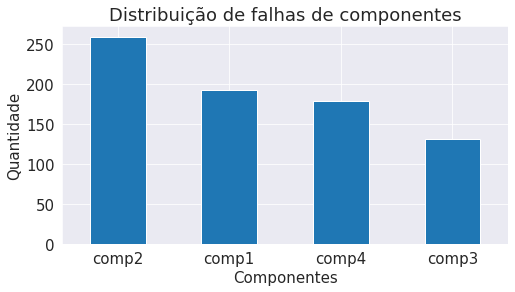

In [35]:
plt.figure(figsize=(8, 4))
falhas_df["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribuição de falhas de componentes")
plt.ylabel("Quantidade")
plt.xlabel("Componentes")
plt.show()

### Engenharia de característica - Feature Engineering

Os dados de telemetria quase sempre vêm com marcações de data/hora, o que os torna adequados para calcular recursos de atraso (estatísticas de determinados valores dentro de uma janela de tempo).

Escolheremos um tamanho de janela e calcularemos medidas agregadas (média, desvio padrão, mínimo, máximo etc.) para representar o histórico de curto prazo.

Em seguida, calcularemos a média móvel e o desvio padrão dos dados de telemetria na última janela de atraso de 3 horas.

In [36]:
# Calculamos valores médios para características de telemetria

temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

# pivotamos porque precisamos do datetime como um índice para que a "resample" funcione
# O resample cria oos intervalos
# closed = 'right' => (6:00, 9:00] ou 6:00 < x <= 9:00
# closed='left' => [6:00, 9:00) ou 6:00 <= x < 9:00
# não pode ser os dois
# unstack: retorna o df ao formato original
# temos 100 máquinas, 4 sensores = 400 colunas
# unstack mostra uma série de dados nas colunas como um índice e retorna uma série (se houver vários índices, eles são reorganizados).
# Cada dataframe em temp possui os valores do campo que lhe corresponde naquele momento.

temp = [
    pd.pivot_table(
        telemetria_df,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").mean().unstack()
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00    170.028993
           2015-01-01 12:00:00    164.192565
           2015-01-01 15:00:00    168.134445
           2015-01-01 18:00:00    165.514453
           2015-01-01 21:00:00    168.809347
dtype: float64

In [37]:
telemetry_mean_3h = pd.concat(temp, axis=1) # Unimos as series.
telemetry_mean_3h.columns = [col + "mean_3h" for col in fields] # Atribuímos nomes de coluna.
telemetry_mean_3h.reset_index(inplace=True) # Achatamos o dataframe.
telemetry_mean_3h.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [38]:
# Repetimos para o desvio padrão.
temp = [
    pd.pivot_table(
        telemetria_df,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").std().unstack()
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00     6.721032
           2015-01-01 12:00:00     7.596570
           2015-01-01 15:00:00    10.124584
           2015-01-01 18:00:00     4.673269
           2015-01-01 21:00:00    14.752132
dtype: float64

In [39]:
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + "sd_3h" for i in fields]
telemetry_sd_3h.reset_index(inplace=True)
telemetry_sd_3h.head()

,machineID,datetime,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,14.752132,47.048609,4.244158,2.207884


In [40]:


# Para capturar um efeito de longo prazo, as funções de atraso de 24 horas também são calculadas.
# Criamos novos valores com médias de 24 horas e, em seguida, selecionamos o primeiro resultado a cada 3 horas.
# Desta forma podemos juntar os resultados com as características de atraso anteriores (calculadas em 3 horas).

temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

temp = [
    pd.pivot_table(
        telemetria_df,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).mean().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00   NaN
           2015-01-01 12:00:00   NaN
           2015-01-01 15:00:00   NaN
           2015-01-01 18:00:00   NaN
           2015-01-01 21:00:00   NaN
dtype: float64

In [41]:
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + "mean_24h" for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
# Devido ao método de média móvel, os primeiros 23 registros são nulos; é preciso removê-los.
# O resultado é um dataframe com menos dados que a telemetria original, bem como a anterior de 3H.
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h["voltmean_24h"].isnull()]

In [42]:
telemetry_mean_24h.head()

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214


In [43]:
# Repetimos para la desviación estándar
temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

temp = [
    pd.pivot_table(
        telemetria_df,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).std().resample("3H", closed="left", label="right").first().unstack(level=-1)
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00   NaN
           2015-01-01 12:00:00   NaN
           2015-01-01 15:00:00   NaN
           2015-01-01 18:00:00   NaN
           2015-01-01 21:00:00   NaN
dtype: float64

In [44]:
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + "sd_24h" for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h["voltsd_24h"].isnull()]

In [45]:
telemetry_sd_24h.head(10)

,machineID,datetime,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,13.954518,43.490234,8.061653,5.898069
12,1,2015-01-02 21:00:00,14.402740,42.626186,10.408012,5.941890
13,1,2015-01-03 00:00:00,15.513819,40.395881,10.833294,5.737671
14,1,2015-01-03 03:00:00,15.726970,39.648116,11.904700,5.601191
15,1,2015-01-03 06:00:00,15.635083,41.828592,11.326412,5.583521
16,1,2015-01-03 09:00:00,13.995465,40.843882,11.036546,5.561553


In [46]:
# Combine os recursos criados até agora.
# Tomamos os valores 2:6 para evitar IDs e datas duplicadas.
# axis=0 nos movemos na direção das linhas, axis=1, nos movemos na direção das colunas.
telemetry_feat = pd.concat([
    telemetry_mean_3h,
    telemetry_sd_3h.iloc[:, 2:6],
    telemetry_mean_24h.iloc[:, 2:6],
    telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069


In [47]:
telemetry_feat.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291300.00000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,170.771416,446.612973,100.855301,40.384328,13.299858,44.456335,8.885822,4.440660,170.772579,446.613440,100.854547,40.384564,14.918849,49.947916,10.046687,5.002065
std,28.86612,9.497201,33.122865,7.408854,3.476641,6.966647,23.216421,4.656341,2.320066,4.716970,18.074248,4.733098,2.059861,2.260726,7.682126,1.713726,0.799820
min,1.00000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.75000,164.445576,427.568132,96.238173,38.147839,8.027455,26.903567,5.370647,2.684308,168.070890,441.549802,98.668589,39.354062,13.358663,44.668824,8.924317,4.460347
50%,50.50000,170.430790,448.385564,100.233139,40.146085,12.495595,41.795700,8.345785,4.173854,170.210913,449.212554,100.097694,40.072752,14.853948,49.613807,9.921407,4.958594
75%,75.25000,176.607051,468.447680,104.404520,42.227392,17.689118,59.103715,11.789645,5.898997,172.459612,456.368008,101.611121,40.833364,16.394764,54.821318,10.980498,5.484480
max,100.00000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783


### Atraso nas marcações de data/hora dos Erros


Assim como os dados de telemetria, os erros vêm com marcações de data/hora. Contamos o número de erros de cada tipo em uma janela atrasada.

In [48]:
"""
Começamos reformatando os dados de erro para ter uma entrada por máquina por vez
quando pelo menos um erro ocorreu.
Criamos uma coluna para cada tipo de erro.
"""
error_count = pd.get_dummies(erros_df) # Colocamos um 1 se o erro aparecer para essa máquina, 0 caso contrário.
error_count.columns = ["datetime", "machineID", "error1", "error2", "error3", "error4", "error5"]
error_count.head(15)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,0,1,0,0
2,2015-01-04 06:00:00,1,0,0,0,0,1
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0
5,2015-01-25 15:00:00,1,0,0,0,1,0
6,2015-01-27 04:00:00,1,1,0,0,0,0
7,2015-03-03 22:00:00,1,0,1,0,0,0
8,2015-03-05 06:00:00,1,1,0,0,0,0
9,2015-03-20 18:00:00,1,1,0,0,0,0


In [49]:
"""
As datas do dataframe se repetem, então agrupamos por data.
Combinamos os erros de uma determinada máquina em um momento específico.
Nós somamos caso haja vários erros do mesmo tipo ao mesmo tempo, mas não esperados.
"""
error_count_grouped = error_count.groupby(["machineID", "datetime"]).sum().reset_index()
error_count_grouped.head(15)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


In [50]:
"""
Verificamos se os erros registrados existem nas máquinas disponíveis preenchidas com 0
não corresponde, portanto, correspondemos apenas a data e hora e machineID.
"""
error_count_filtered = telemetria_df[["datetime", "machineID"]].merge(
    error_count_grouped,
    on=["machineID", "datetime"],
    how="left"
).fillna(0.0)

error_count_filtered.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0


In [51]:
# Verificamos se não há anomalias.
error_count_filtered.describe()

,machineID,error1,error2,error3,error4,error5
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,0.001147,0.001128,0.000958,0.000813,0.000392
std,30.450409,0.033848,0.033573,0.030938,0.028493,0.019803
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# Calculamos la cantidad total de errores para cada tipo de error durante lapsos de 24 horas. 
# Tomaremos puntos cada 3 horas.

temp = []
fields = [
    "error%d" % i
    for i in range(1,6)
]

temp = [
    pd.pivot_table(
        error_count_filtered,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).sum().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head(10)

machineID  datetime           
1          2015-01-01 09:00:00    NaN
           2015-01-01 12:00:00    NaN
           2015-01-01 15:00:00    NaN
           2015-01-01 18:00:00    NaN
           2015-01-01 21:00:00    NaN
           2015-01-02 00:00:00    NaN
           2015-01-02 03:00:00    NaN
           2015-01-02 06:00:00    0.0
           2015-01-02 09:00:00    0.0
           2015-01-02 12:00:00    0.0
dtype: float64

In [53]:
error_count_total = pd.concat(temp, axis=1)
error_count_total.columns = [i + "count" for i in fields]
error_count_total.reset_index(inplace=True)
error_count_total = error_count_total.dropna()
error_count_total.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


In [54]:
error_count_total["error5count"].unique()

array([0., 1., 2.])

In [55]:
error_count_total.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


### Tempo desde a última substituição de manutenção

Os logs de manutenção contêm as informações dos logs de substituição de componentes. Possíveis recursos deste conjunto de dados podem ser calcular quanto tempo se passou desde a última substituição de um componente, pois quanto mais tempo um componente é usado, maior a degradação.

Nesta seção, o conhecimento do domínio desempenha um papel importante na compreensão dos preditores de um problema. Os dias desde a última substituição de componente são calculados para cada tipo de componente como características dos dados de manutenção.

In [56]:
manutencao_df.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [57]:
# creamos una columna para cada tipo de error
comp_rep = pd.get_dummies(manutencao_df)
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2014-06-01 06:00:00,1,0,1,0,0
1,2014-07-16 06:00:00,1,0,0,0,1
2,2014-07-31 06:00:00,1,0,0,1,0
3,2014-12-13 06:00:00,1,1,0,0,0
4,2015-01-05 06:00:00,1,0,0,0,1


In [58]:
# Combinamos correções para uma determinada máquina em um determinado momento.
# Se não agruparmos por data podemos ver outra perspectiva.
# Descubra quais componentes falham juntos, conforme agrupamos por data.
comp_rep = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()
comp_rep.head()

,machineID,datetime,comp1,comp2,comp3,comp4
0,1,2014-06-01 06:00:00,0,1,0,0
1,1,2014-07-16 06:00:00,0,0,0,1
2,1,2014-07-31 06:00:00,0,0,1,0
3,1,2014-12-13 06:00:00,1,0,0,0
4,1,2015-01-05 06:00:00,1,0,0,1


In [59]:
# soma os horários em que não houve substituições
comp_rep = telemetria_df[["datetime", "machineID"]].merge(
    comp_rep,
    on=["datetime", "machineID"],
    how="outer").fillna(0).sort_values(by=["machineID", "datetime"]
)
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
968588,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0
968589,2014-07-16 06:00:00,1,0.0,0.0,0.0,1.0
968590,2014-07-31 06:00:00,1,0.0,0.0,1.0,0.0
968591,2014-12-13 06:00:00,1,1.0,0.0,0.0,0.0
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0


In [60]:
components = ["comp1", "comp2", "comp3", "comp4"]
for comp in components:
    # Queremos obter a data da alteração mais recente do componente.
    comp_rep.loc[comp_rep[comp] < 1, comp] = None # Preencher amostras sem reposição com null.
    # as datas das entradas que têm substituições.
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    # Preenchemos as datas mais recentes de uma alteração de componente.
    # Preencha com o último valor válido encontrado de cima para baixo.
    comp_rep[comp] = pd.to_datetime(comp_rep[comp].fillna(method="ffill"))

# eliminamos amostras de 2014, poderiam ter nulos, a manutenção começou nesse ano.
comp_rep = comp_rep.loc[comp_rep["datetime"] > pd.to_datetime("2015-01-01")]
comp_rep.head(50)

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
1,2015-01-01 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
2,2015-01-01 07:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
3,2015-01-01 07:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
4,2015-01-01 08:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
5,2015-01-01 08:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
6,2015-01-01 09:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
7,2015-01-01 09:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
8,2015-01-01 10:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
9,2015-01-01 10:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00


In [61]:
# Substituimos as datas de alteração mais recentes pelo número de dias desde a alteração mais recente.
for comp in components: comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
2,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
3,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
4,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333


In [62]:
comp_rep.describe()

,machineID,comp1,comp2,comp3,comp4
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,54.634332,51.758970,53.299393,52.278293
std,30.450409,63.826724,60.670415,59.018920,57.948910
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,13.333333,11.875000,13.208333,12.833333
50%,45.000000,33.291667,29.333333,32.625000,31.875000
75%,73.000000,70.125000,66.041667,68.375000,68.375000
max,100.000000,491.958333,348.958333,370.958333,394.958333


### Características das Máquinas

As características das máquinas podem ser usadas ​​sem modificações adicionais. Estas características incluem informações descritivas sobre o tipo de cada máquina e sua idade (número de anos em serviço).

In [63]:
# Finalmente unimos todas as características 'features' criadas.
final_feat = telemetry_feat.merge(error_count_total, on=["datetime", "machineID"], how="left")
final_feat = final_feat.merge(comp_rep, on=["datetime", "machineID"], how="left")
final_feat = final_feat.merge(maquinas_df, on=["machineID"], how="left")
final_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
2,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
3,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
4,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18


In [64]:
final_feat.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,...,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000
mean,46.231192,170.768411,446.597577,100.838149,40.383141,13.302106,44.455735,8.881637,4.440767,170.769676,...,0.027521,0.027098,0.022925,0.019497,0.009421,54.457997,51.526382,53.080321,52.069375,11.201010
std,30.450378,9.491411,33.167382,7.383769,3.470424,6.969309,23.216651,4.652646,2.320059,4.709159,...,0.165689,0.164310,0.151480,0.139316,0.097084,63.755660,60.536692,58.907684,57.844919,5.805725
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,164.445707,427.538361,96.232695,38.149663,8.028952,26.901973,5.369147,2.684075,168.070800,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,11.875000,13.125000,12.750000,7.000000
50%,45.000000,170.424831,448.393472,100.223955,40.145593,12.491269,41.802809,8.343671,4.173235,170.209023,...,0.000000,0.000000,0.000000,0.000000,0.000000,33.125000,29.250000,32.500000,31.750000,11.000000
75%,73.000000,176.606136,468.433119,104.391447,42.229040,17.690162,59.097634,11.785599,5.901163,172.455485,...,0.000000,0.000000,0.000000,0.000000,0.000000,69.875000,65.656250,68.000000,68.000000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,...,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000


In [65]:
final_feat.columns

Index(['machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'model', 'age'],
      dtype='object')

### Construção dos Rótulos (Váriável objetivo / Variável Dependente)


Quando a classificação multiclasse é usada para prever falhas devido a um problema, a marcação é feita tomando uma janela de tempo antes que um ativo falhe e rotulando os registros de recursos que se enquadram nessa janela como "prestes a falhar devido a uma falha". " enquanto rotula todos os outros registros como "normais". Essa janela de tempo deve ser selecionada de acordo com a regra de negócio: em algumas situações, prever falhas com horas de antecedência pode ser suficiente, enquanto em outras, dias ou semanas de antecedência pode ser necessário.

In [66]:
final_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
2,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
3,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
4,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18


O objetivo é calcular a probabilidade de uma máquina falhar nas próximas 24 horas devido à falha de um determinado componente.

Em seguida, um recurso de falha categórica é criado para servir como um rótulo. Todos os logs em uma janela de 24 horas antes de uma falha do componente 1 têm error=comp1 e assim por diante para os componentes 2, 3 e 4; Todos os logs fora de 24 horas após uma falha de componente apresentam falha = nenhum

In [67]:
"""
Estamos informando ao modelo que quaisquer valores semelhantes aos que estão dentro da janela de 24 horas
é uma falha desse componente, por isso as máquinas se repetem.
Usamos limite=7 porque temos separações de 3 horas; 8 * 3 = 24 horas
mas levamos em consideração o primeiro valor não nulo, então é 7.
"""
labeled_features = final_feat.merge(falhas_df, on=["datetime", "machineID"], how="left")
# Aplicamos um preenchimento inverso de até 24h.
# fillna não trabalha com tipos categóricos no momento (como a nova categoria se encaixaria? talvez).
# Passamos para objeto ou string, aplicamos a operação e voltamos para categoria.
labeled_features["failure"] = labeled_features["failure"].astype(object).fillna(method="bfill", limit=7)
labeled_features["failure"] = labeled_features["failure"].fillna("none")
labeled_features["failure"] = labeled_features["failure"].astype("category")
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
2,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
3,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
4,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none


In [68]:
model_dummies = pd.get_dummies(labeled_features["model"])
labeled_features = pd.concat([labeled_features, model_dummies], axis=1)
labeled_features.drop("model", axis=1, inplace=True)

In [69]:
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,comp1,comp2,comp3,comp4,age,failure,model1,model2,model3,model4
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,20.000,215.000,155.000,170.000,18,none,0,0,1,0
1,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,20.000,215.000,155.000,170.000,18,none,0,0,1,0
2,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,20.125,215.125,155.125,170.125,18,none,0,0,1,0
3,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,20.125,215.125,155.125,170.125,18,none,0,0,1,0
4,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,20.250,215.250,155.250,170.250,18,none,0,0,1,0


### Análise de correlação

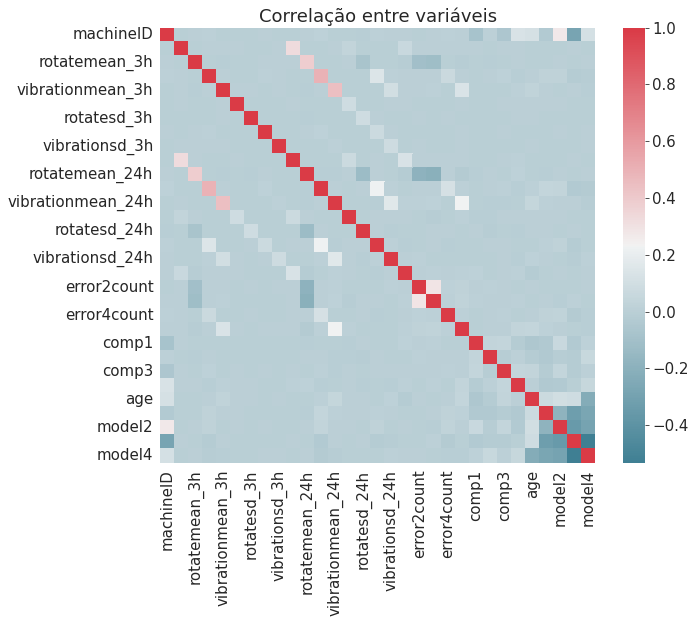

In [70]:
# É necessário eliminar as variáveis ​​com alta correlação (apenas uma), considerar > 70%.
f, ax = plt.subplots(figsize=(10, 8))
corr = labeled_features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title("Correlação entre variáveis")
plt.show()

### Salve para aplicar a otimização de hiperparâmetros.
### labeled_features.to_pickle("final_datset.pickle")

## Modelagem

### Treinamento, Validação e Teste

Ao trabalhar com séries temporais como neste exemplo, o particionamento do dataset em treinamento, validação e teste deve ser feito com cuidado para evitar superestimar o desempenho dos modelos. Na manutenção preditiva, os recursos geralmente são gerados usando agregados defasados: os registros na mesma janela de tempo provavelmente terão rótulos idênticos e valores de recursos semelhantes. Essas correlações podem dar a um modelo uma "vantagem injusta" na previsão de um registro do conjunto de teste que compartilha sua janela de tempo com um registro do conjunto de treinamento. Portanto, dividimos os registros em conjuntos de treinamento, validação e teste em grandes partes, para minimizar o número de intervalos de tempo compartilhados entre eles.

Os modelos preditivos não possuem conhecimento avançado das tendências de tempo futuras: na prática, tais tendências provavelmente existirão e terão um impacto adverso no desempenho do modelo. Para obter uma avaliação precisa do desempenho de um modelo preditivo, é recomendável realizar treinamento em registros mais antigos e validação/teste usando registros mais recentes.

Por ambos os motivos, uma estratégia de divisão de log dependente do tempo é uma excelente opção para modelos de manutenção preditiva. A divisão é feita escolhendo um ponto no tempo com base no tamanho desejado dos conjuntos de treinamento e teste: todos os registros anteriores ao ponto no tempo são usados ​​para treinar o modelo e todos os registros restantes são usados ​​para teste.

In [71]:
# Estabelecemos os tempos correspondentes aos registros que serão utilizados para treinamento e testes.
threshold_dates = [
    pd.to_datetime("2015-09-30 01:00:00"), pd.to_datetime("2015-10-01 01:00:00")
]

In [72]:
test_results = []
models = []
total = len(threshold_dates)


last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [73]:
# Normalmente, 20-30% dos dados são usados.
ntraining = labeled_features.loc[labeled_features["datetime"] < last_train_date]
ntesting = labeled_features.loc[labeled_features["datetime"] > first_test_date]
print(f"{ntraining.shape[0]} Treinamento.")
print(f"{ntesting.shape[0]} Teste.")
print(f"{ntesting.shape[0] / ntraining.shape[0] * 100:0.1f}% dos dados usados para teste.")

240023 Treinamento.
81189 Teste.
33.8% dos dados usados para teste.


In [74]:
fails_train = ntraining[ntraining["failure"] != "none"].shape[0]
no_fails_train = ntraining[ntraining["failure"] == "none"].shape[0]
fails_test = ntesting[ntesting["failure"] != "none"].shape[0]
no_fails_test = ntesting[ntesting["failure"] == "none"].shape[0]

print(f"{fails_train / no_fails_train * 100:0.1f}% dos casos são falhas no conjunto de treinamento.")
print(f"{fails_test / no_fails_test * 100:0.1f}% dos casos são falhas do conjunto de teste.")

1.8% dos casos são falhas no conjunto de treinamento.
1.7% dos casos são falhas do conjunto de teste.


In [75]:
# Atribuímos os valores correspondentes aos treinos e testes.
train_y = labeled_features.loc[labeled_features["datetime"] < last_train_date, "failure"]
train_X = labeled_features.loc[labeled_features["datetime"] < last_train_date].drop(["datetime",
                                                                                    "machineID",
                                                                                    "failure"], axis=1)
test_y = labeled_features.loc[labeled_features["datetime"] > first_test_date, "failure"]
test_X = labeled_features.loc[labeled_features["datetime"] > first_test_date].drop(["datetime",
                                                                                   "machineID",
                                                                                   "failure"], axis=1)

In [76]:
train_y

0         none
1         none
2         none
3         none
4         none
          ... 
321341    none
321342    none
321343    none
321344    none
321345    none
Name: failure, Length: 240023, dtype: category
Categories (5, object): ['comp1', 'comp2', 'comp3', 'comp4', 'none']

In [144]:
test_X

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,error5count,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
4350,170.301017,449.036995,94.805205,40.816797,11.061667,58.425055,4.931305,2.428740,178.008406,453.336357,...,0.0,28.875,13.875,118.875,28.875,18,0,0,1,0
4351,170.301017,449.036995,94.805205,40.816797,11.061667,58.425055,4.931305,2.428740,178.008406,453.336357,...,0.0,28.875,13.875,118.875,28.875,18,0,0,1,0
4352,165.339972,435.660354,103.351320,31.892462,10.717864,26.009485,22.071933,6.020669,178.277009,452.064940,...,0.0,29.000,14.000,119.000,29.000,18,0,0,1,0
4353,165.339972,435.660354,103.351320,31.892462,10.717864,26.009485,22.071933,6.020669,178.277009,452.064940,...,0.0,29.000,14.000,119.000,29.000,18,0,0,1,0
4354,183.752875,463.058640,109.525083,41.945037,9.369264,43.646584,10.859804,9.395067,176.380067,444.022795,...,0.0,29.125,14.125,119.125,29.125,18,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322087,177.758754,458.391629,103.183160,46.846592,13.147011,75.100940,3.111700,3.576693,169.764418,454.478787,...,0.0,82.500,7.500,82.500,52.500,5,0,0,0,1
322088,166.078945,424.431184,98.344409,30.907459,29.351231,69.348245,16.940674,3.731256,171.547643,452.351565,...,0.0,82.625,7.625,82.625,52.625,5,0,0,0,1
322089,158.327984,504.056262,108.055441,40.109705,9.605817,78.036116,9.154932,3.379639,168.806645,459.502212,...,0.0,82.750,7.750,82.750,52.750,5,0,0,0,1
322090,170.306956,438.653616,102.346227,47.481232,8.457322,43.021553,0.785721,3.198928,169.011763,465.923073,...,0.0,82.875,7.875,82.875,52.875,5,0,0,0,1


In [145]:
pred = model.predict(test_X)

array(['none', 'none', 'none', ..., 'none', 'none', 'none'], dtype=object)

In [78]:
# Treinamento do modelo.
# model = GradientBoostingClassifier(random_state=42)
model = xgb(n_jobs=-1)
model.fit(train_X, train_y);

In [91]:
# Obtenha resultados no conjunto de testes.
test_result = pd.DataFrame(labeled_features.loc[labeled_features["datetime"] > first_test_date])
test_result["predicted_failure"] = model.predict(test_X)
test_results.append(test_result)
models.append(model)

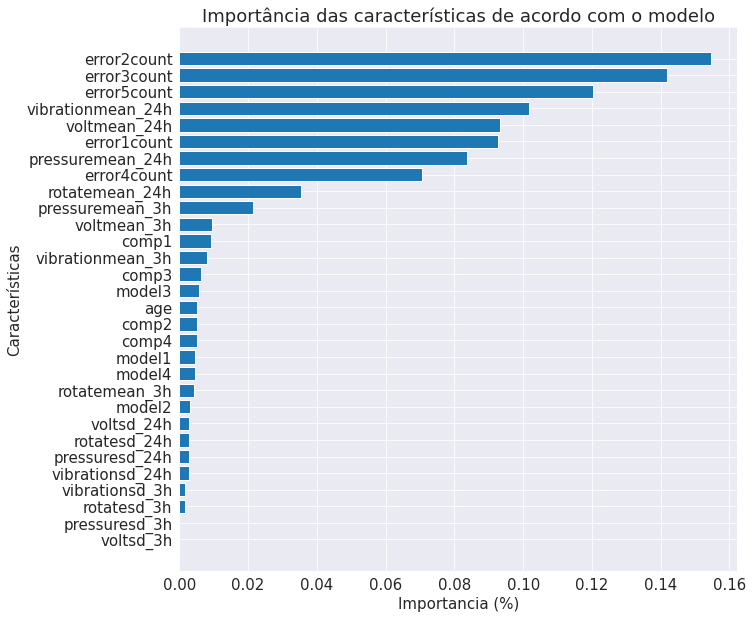

In [92]:
# Abaixo, plotamos as importâncias das características no (primeiro) modelo treinado
plt.figure(figsize=(10, 10))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=False, key=lambda x: x[1]))
plt.yticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.barh(range(len(importances)), importances)
plt.ylabel("Características")
plt.xlabel("Importancia (%)")
plt.title("Importância das características de acordo com o modelo")
plt.show()

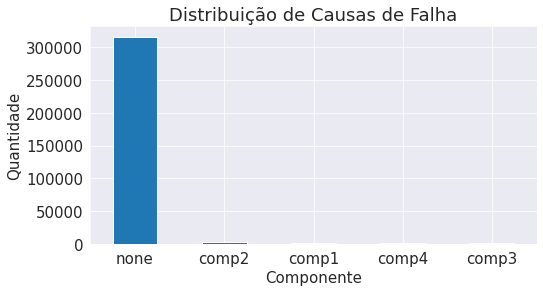

In [93]:
# Existe um desequilíbrio esperado.
plt.figure(figsize=(8, 4))
labeled_features["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribuição de Causas de Falha")
plt.xlabel("Componente")
plt.ylabel("Quantidade")
plt.show()

In [94]:
def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calcular e exibir a matriz de confusão
    cm = confusion_matrix(actual, predicted, labels=labels)
    #print("Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels")
    #print(cm)
    
    # Calcula precisão, recall e pontuação F1
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(["accuracy", "precision", "recall", "F1"])
    
    # Calcular as versões macro dessas métricas
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(["macro precision", "macro recall", "macro F1"])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(["average accuracy",
                          "micro-averaged precision/recall/F1"])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(["majority class accuracy", "majority class recall",
                          "majority class precision", "majority class F1"])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(["expected accuracy", "kappa"])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(["random guess accuracy", "random guess precision",
                          "random guess recall", "random guess F1"])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(["random weighted guess accuracy",
                          "random weighted guess precision",
                          "random weighted guess recall",
                          "random weighted guess F1"])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

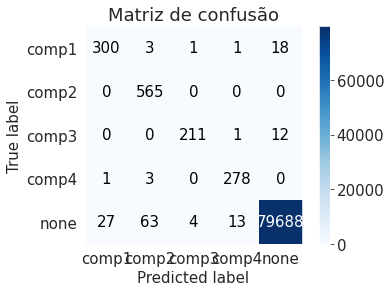

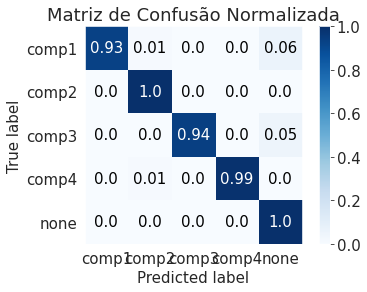

,none,comp1,comp2,comp3,comp4
accuracy,0.998189,0.998189,0.998189,0.998189,0.998189
precision,0.999624,0.914634,0.891167,0.976852,0.948805
recall,0.998659,0.928793,1.000000,0.941964,0.985816
F1,0.999141,0.921659,0.942452,0.959091,0.966957
macro precision,0.946216,0.946216,0.946216,0.946216,0.946216
macro recall,0.971046,0.971046,0.971046,0.971046,0.971046
macro F1,0.957860,0.957860,0.957860,0.957860,0.957860
average accuracy,0.999276,0.999276,0.999276,0.999276,0.999276
micro-averaged precision/recall/F1,0.998189,0.998189,0.998189,0.998189,0.998189
majority class accuracy,0.982830,0.000000,0.000000,0.000000,0.000000


In [83]:
evaluation_results = []
test_result = test_results[0]
evaluation_result = Evaluate(actual = test_result["failure"],
                             predicted = test_result["predicted_failure"],
                             labels = ["none", "comp1", "comp2", "comp3", "comp4"])
skplt.metrics.plot_confusion_matrix(
    test_result["failure"],
    test_result["predicted_failure"],
    normalize=False,
    title="Matriz de confusão"
)

skplt.metrics.plot_confusion_matrix(
    test_result["failure"],
    test_result["predicted_failure"],
    normalize=True,
    title="Matriz de Confusão Normalizada",
)
plt.show()

evaluation_results.append(evaluation_result)
evaluation_results[0]  # show full results for first split only

NOTA: Precision = TP / (TP + FP). 
Recall = TP (TP + FN). 
F1 = 2 * (precision * recall) / (precision + recall)

Estamos interessados ​​em quantos erros foram encontrados (recordação).

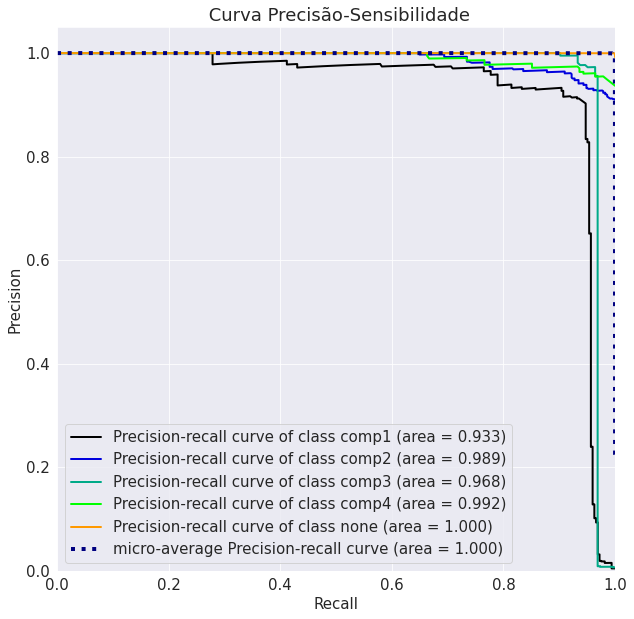

In [95]:
# Para um problema de classificação binária, geralmente é usada a curva ROC-AUC.
# Para este caso multiclasse, usaremos precisão versus sensibilidade.
skplt.metrics.plot_precision_recall_curve(
    test_y,
    model.predict_proba(test_X),
    title=" Curva Precisão-Sensibilidade",
    figsize=(10,10)
)
plt.show()

In [96]:
evaluation_results[0].loc["recall"].values

array([0.99865906, 0.92879257, 1.        , 0.94196429, 0.9858156 ])

In [86]:
recall_df = pd.DataFrame([evaluation_results[0].loc["recall"].values],
                         columns=["none", "comp1", "comp2", "comp3", "comp4"],
                         index=["Sensibilidade por Componente"])
recall_df.T

,Sensibilidade por Componente
none,0.998659
comp1,0.928793
comp2,1.000000
comp3,0.941964
comp4,0.985816


In [97]:
test_values = train_X.iloc[0].values
test_values

array([180.13378397, 440.60832011,  94.1379695 ,  41.55154363,
        21.32273479,  48.77051197,   2.13568373,  10.03720806,
       169.7338089 , 445.1798646 ,  96.79711296,  40.38515999,
        11.23312028,  48.71739478,  10.07988023,   5.85320856,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  20.        , 215.        , 155.        ,
       170.        ,  18.        ,   0.        ,   0.        ,
         1.        ,   0.        ])

In [140]:
# XGBoost aceita apenas arrays bidimensionais.
single_test = pd.DataFrame([test_values], columns=test_X.columns, index=[0])
single_test

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,error5count,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,180.133784,440.60832,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,...,0.0,20.0,215.0,155.0,170.0,18.0,0.0,0.0,1.0,0.0


In [141]:
probas = model.predict_proba(test_X.iloc[[]])
prediction = model.predict(test_X.iloc[28455:30000])
ordered_classes = np.unique(np.array(test_y))

In [147]:
# test_y[test_y == "comp1"]
test_X.iloc[[28455]


,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,error5count,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
5798,153.940587,471.123066,92.651341,37.987362,4.820657,10.70348,11.434798,7.074329,168.712679,461.26663,...,0.0,89.375,44.375,29.375,14.375,18,0,0,1,0


In [143]:
results = pd.DataFrame(probas,
                       columns=ordered_classes
                       )
print(f"Predição: {prediction}")
results.head(200)

Predição: ['none' 'none' 'none' ... 'none' 'none' 'none']


,comp1,comp2,comp3,comp4,none
0,0.000049,0.000049,0.000069,0.000049,0.999782
1,0.000045,0.000045,0.000045,0.000045,0.999821
2,0.000045,0.000045,0.000045,0.000045,0.999821
3,0.000045,0.000045,0.000045,0.000045,0.999821
4,0.000045,0.000045,0.000045,0.000045,0.999821
...,...,...,...,...,...
195,0.000020,0.000020,0.000020,0.000020,0.999920
196,0.000020,0.000020,0.000020,0.000020,0.999920
197,0.000020,0.000020,0.000020,0.000020,0.999920
198,0.000020,0.000020,0.000020,0.000020,0.999920


In [148]:
p = model.predict(test_X.iloc[[1448 ]])

In [149]:
p

array(['none'], dtype=object)